In [132]:
import pandas as pd
import numpy as np
import re
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1
from gensim.models import FastText
import ipdb
import spacy
import tqdm

In [131]:
# !pip install ipdb
# !pip install torchmetrics

In [134]:
# !wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
# !wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv

In [135]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [136]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets['tone'] = 0

In [137]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [138]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [139]:
def preprocess(text): 
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.split()

In [140]:
tweets_data['prep_text'] = tweets_data.text.apply(lambda x: ' '.join(preprocess(x)))

In [141]:
tweets_data

,text,tone,prep_text
69709,"@byundey я не поняла, чего так поздно легла? /...",0,USER я не поняла чего так поздно легла мне мож...
107292,RT @ElDLV: Последнее время у меня совсем упала...,0,rt USER последнее время у меня совсем упала ак...
55412,"RT @valerka_mr: @EvgeniyBrobar о_О,это даже не...",0,rt USER USER о о это даже не зависть это завии...
114899,@legenda_cao ты Чё там один чтоль?:D в тви все...,1,USER ты че там один чтоль d в тви всем похуй н...
5389,@AcklesJennny @Dean35111 @mishacoll1ns @OldSch...,1,USER USER USER USER я не хочу спать совершенно...
...,...,...,...
88973,"Экзамены специально делают после Нового Года, ...",1,экзамены специально делают после нового года ч...
51351,"Завтра много дел учеба, репетиторы, а вечером ...",0,завтра много дел учеба репетиторы а вечером уб...
88156,Ещё чуть чуть и выходные)Вечерний чат) http://...,1,еще чуть чуть и выходные вечерний чат URL
70187,"@sladmed_sdd ну когда тебя увижу,обязательно п...",1,USER ну когда тебя увижу обязательно поставлю


In [142]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.2)

In [143]:
train_sentences[train_sentences.tone == 1].shape[0] /train_sentences.shape[0]

0.50645

In [144]:
vocab = Counter()

for text in tweets_data['prep_text']:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 111482


In [145]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 5 раз: 14823


In [146]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [147]:
id2word = {i:word for word, i in word2id.items()}

In [148]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [149]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [150]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [151]:
batch = next(iter(train_iterator))
batch[0].shape

torch.Size([1024, 22])

In [152]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [153]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 22])

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=3, padding='same')
        self.ngrams_cat = nn.Conv1d(in_channels=140, out_channels=140, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=140, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        #feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        #feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))


        #pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        #pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        #concat = torch.cat((pooling1, pooling2), 1)
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        pooling = self.dropout(self.pooling(self.relu(self.ngrams_cat(concat))))
        bm = pooling.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.dropout(self.hidden(bm)) 
        logits = self.out(logits)       
        return logits

### Training model

In [154]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [155]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке


In [ ]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### Обучим эмбеддинг слой на нашей модели

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7728822912488665
Train loss: 0.740883849818131
Train loss: 0.7273916561495174
Train loss: 0.7201391094821995
Train loss: 0.7154259432006527

Evaluating on train...
Val loss: 0.7397012327398572, Val f1: 0.5624197125434875
Val loss: 0.7141710047064156, Val f1: 0.5446305274963379
Val loss: 0.7062113583087921, Val f1: 0.5389561653137207
Val loss: 0.7023199140015295, Val f1: 0.533118486404419
Val loss: 0.699858270786904, Val f1: 0.5331370234489441

Evaluating on test...
Val loss: 0.9208655754725138, Val f1: 0.7106255292892456
Val loss: 0.7895575336047581, Val f1: 0.5950040817260742
Val loss: 0.754049382426522, Val f1: 0.5673853158950806
Val loss: 0.7374019980430603, Val f1: 0.555588960647583
Val loss: 0.7276801027749714, Val f1: 0.545220673084259

starting Epoch 1
Training...
Train loss: 0.7479570124830518
Train loss: 0.7215956552275296
Train loss: 0.7129712145436894
Train loss: 0.708915385149293
Train loss: 0.7063830349896405

Evaluating on train

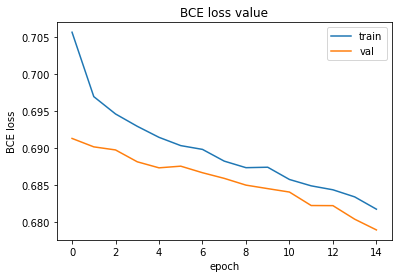

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

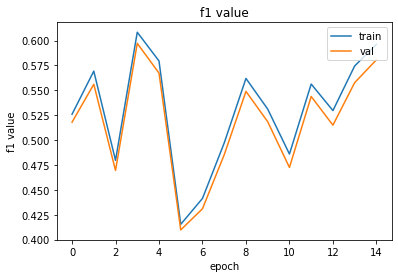

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [156]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)

In [ ]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.5827801247233958

результаты сомнительные...графики тоже не очень, попробуем улучшить модель.

In [ ]:
fn[:5]

['ну так надо на а не по за 3',
 'я так устала от уже даже не на это',
 'театре долго ждала маму из поэтому надела ее шубу на свой пуховик и ходила вдоль со ржали',
 'я получила свою вот теперь в свои я по дому в одежде',
 'ну так это ведь не к к']

### Подгрузим эмбеддинги Fasttext

In [157]:
texts = tweets_data.prep_text.tolist()

In [158]:
ft = FastText(texts, size=100, window=5, min_count=1)

In [159]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [160]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=3, padding='same')
        self.ngrams_cat = nn.Conv1d(in_channels=140, out_channels=140, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=140, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        pooling = self.dropout(self.pooling(self.relu(self.ngrams_cat(concat))))
        bm = pooling.max(2)[0]
        logits = self.dropout(self.hidden(bm)) 
        logits = self.out(logits)       
        return logits

In [161]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [162]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7814411435808454
Train loss: 0.7423167845298504
Train loss: 0.7262157432057641
Train loss: 0.719205477480161
Train loss: 0.7149461435305106

Evaluating on train...
Val loss: 0.7365803505693164, Val f1: 0.6100801229476929
Val loss: 0.710307240486145, Val f1: 0.5947532057762146
Val loss: 0.7025547569448297, Val f1: 0.5891904830932617
Val loss: 0.6982806577520856, Val f1: 0.585996687412262
Val loss: 0.6957472103673059, Val f1: 0.5861843824386597

Evaluating on test...
Val loss: 0.914421816666921, Val f1: 0.770666241645813
Val loss: 0.7841137136731829, Val f1: 0.666946291923523
Val loss: 0.7485581365498629, Val f1: 0.6398109197616577
Val loss: 0.7317839940388997, Val f1: 0.6266723871231079
Val loss: 0.7222582195934496, Val f1: 0.6111502051353455

starting Epoch 1
Training...
Train loss: 0.7472650791917529
Train loss: 0.7186078305902153
Train loss: 0.7104037932374261
Train loss: 0.7062312506012998
Train loss: 0.7039341258036124

Evaluating on trai

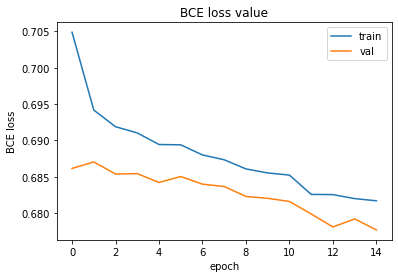

In [163]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

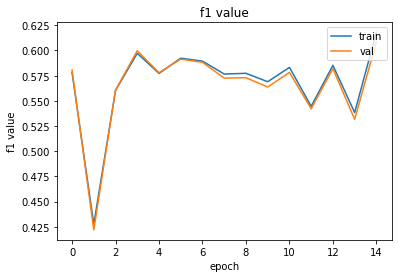

In [164]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [165]:
fp, fn, tp, tn = predict(model, val_iterator)

In [166]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.6107257985738009

In [167]:
fn[:5]

['сижу сдаю заявку в и слышу в обсуждают',
 'меня в словах на',
 '4',
 'ubuntu я пропустил это событие',
 'какая я по классу и все оттуда потом еще']

Подруженные эмбеддинги не улучшили результаты :(

Попробуем убрать предобработку текстов совсем. От переобучения я уже спасла модель тем, что добавила Dropout, уменьшила embedding_dim до 5, уменьшила in_features (и соответственно out_channels) до 140, разделила текст на train/val как 8 к 2. Learning rate 0.001 тоже помогает улучшить результаты + небольшое кол-во эпох предотвращает переобучение.

In [168]:
vocab = Counter()
for text in tweets_data['text']:
    vocab.update(text.split(' '))
for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [169]:
class RawTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [170]:
train_dataset = RawTweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [171]:
val_dataset = RawTweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [172]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [173]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7533844113349915
Train loss: 0.7229097177242411
Train loss: 0.7129018509929831
Train loss: 0.707466418460264
Train loss: 0.7041913963652946

Evaluating on train...
Val loss: 0.7220345267227718, Val f1: 0.6741688847541809
Val loss: 0.697746729028636, Val f1: 0.6479036808013916
Val loss: 0.6897455602884293, Val f1: 0.6428357362747192
Val loss: 0.6861391491809133, Val f1: 0.6375938653945923
Val loss: 0.683790782013455, Val f1: 0.6354176998138428

Evaluating on test...
Val loss: 0.8988829851150513, Val f1: 0.8426790237426758
Val loss: 0.7709891455514091, Val f1: 0.7227709889411926
Val loss: 0.7358996976505626, Val f1: 0.6917389631271362
Val loss: 0.7196229656537374, Val f1: 0.674662172794342
Val loss: 0.7103475206776669, Val f1: 0.6615768074989319

starting Epoch 1
Training...
Train loss: 0.7336540307317462
Train loss: 0.7066124040504982
Train loss: 0.6979179964824156
Train loss: 0.6918887536404497
Train loss: 0.6874370164162403

Evaluating on tr

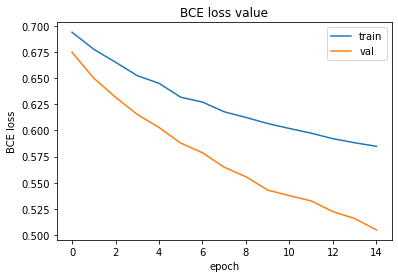

In [174]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

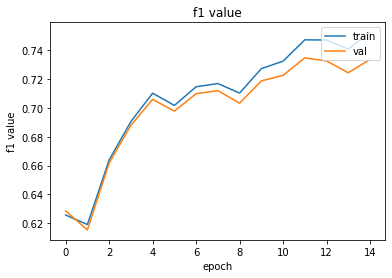

In [175]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [176]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7341834962536595

Результаты стали лучше, ура! По всей видимости, чем больше информации о тексте получает модель, тем лучше она справляется с задачей. Тем более при оценки тональности текстов в соц. сетях нужно учитывать смайлики/знаки препинания/скобки и тд, тк они важные индикаторы "настроения" автора. Посмотрим на ошибки модели.

In [177]:
fp[:5]

['@SFGO76 я ей верил даже больше чем Ни',
 'Вокруг происходит какая-то неведомая фигня! Все, кто собирался в никак не могут  Это и к тебе',
 'ай лайк Дима хи из соу ай ту',
 'всего быть человеком,',
 'говоря, со всей этой никакого новогоднего                 ']

In [178]:
fn[:5]

['для начала встретиться',
 'да какая как будто от этого что-нибудь поменялось',
 'какая я по классу и все оттуда ахаха, потом еще Весело',
 '',
 'в автобусе было на самой']

### Модель с комбинацией эмбеддингов и символьных признаков

In [ ]:
vocab = Counter()
for text in tweets_data['prep_text']:
    vocab.update(text.split())

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

уникальных токенов, втретившихся больше 5 раз: 14917


In [ ]:
char_vocab = Counter()
for text in tweets_data['prep_text']:
    for word in text:
      char_vocab.update(list(word))

filtered_char_vocab = set()

for word in char_vocab:
    if char_vocab[word] > 10:
        filtered_char_vocab.add(word)
print('уникальных токенов, втретившихся больше 10 раз:', len(filtered_char_vocab))

symbol2id = {'PAD':0}

for symbol in filtered_char_vocab:
    symbol2id[symbol] = len(symbol2id)

уникальных токенов, втретившихся больше 10 раз: 73


In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [ ]:
ft_2 = FastText(tweets_data['prep_text'].tolist(), size=100, window=5, min_count=1)

In [ ]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft_2.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [ ]:
class WSTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['prep_text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [ ]:
train_dataset = WSTweetsDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
val_dataset = WSTweetsDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
class WSCNN(nn.Module):
    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

        # word-level
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(100, 100) 

        # symbol-level
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)

        # both
        self.relu = nn.ReLU()   
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5) 
        self.out = nn.Sigmoid()

    def forward(self, words_seq, symb_seq):
        #batch_size x seq_len
        embedded = self.symb_embedding(symb_seq)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded)))) 
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded)))) 
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch_size x (filter_count2 + filter_count3)
        symb_vector = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq) 
        mean_emb_words = torch.mean(embedded_words, dim=1) 
        word_vector = self.dropout(self.word_hidden(mean_emb_words)) # тут был дропаут
        word_vector = self.dropout(self.relu(word_vector)) # тут был дропаут
        concat = torch.cat((symb_vector, word_vector), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (word_seq, symb_seq, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(word_seq, symb_seq)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in enumerate(iterator):   
            preds = model(word_seq, symb_seq)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке


In [ ]:
model = WSCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7970502589430127
Train loss: 0.7439993249958959
Train loss: 0.7234059233557094
Train loss: 0.7108699275275409
Train loss: 0.7016369998455048

Evaluating on train...
Val loss: 0.711431486266, Val f1: 0.7110620141029358
Val loss: 0.6872936487197876, Val f1: 0.6851364374160767
Val loss: 0.6793504817919298, Val f1: 0.6788883805274963
Val loss: 0.6754608750343323, Val f1: 0.6748223900794983
Val loss: 0.6732387301084157, Val f1: 0.6728519797325134

Evaluating on test...
Val loss: 0.8837892214457194, Val f1: 0.8960347175598145
Val loss: 0.758181129183088, Val f1: 0.7598348259925842
Val loss: 0.7235158302567222, Val f1: 0.7296117544174194
Val loss: 0.7083022197087606, Val f1: 0.7111564874649048
Val loss: 0.6997516217984652, Val f1: 0.6997172832489014

starting Epoch 1
Training...
Train loss: 0.7021045429365975
Train loss: 0.6740649239770298
Train loss: 0.6632606807080182
Train loss: 0.6542869483010244
Train loss: 0.6474765716372309

Evaluating on tra

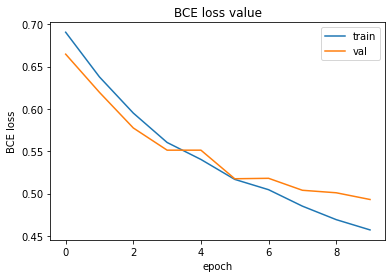

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

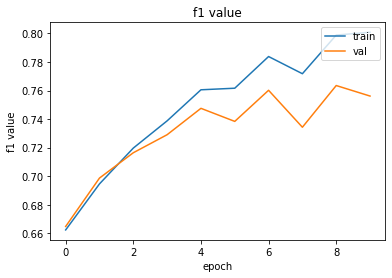

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in enumerate(iterator):  
            preds = model(word_seq, symb_seq)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, word_seq):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7563133185075365

In [ ]:
tp[:5]

['USER давно не вам удачи вперед мои любимые ребята',
 'как дела что делаете как настроение а хотя вы такие пидары что не d',
 'нас уже 1 и так держать мы и дальше будем стараться для вас спасибо что вы с нами URL',
 'USER под тренд пусть лучше он под нас',
 'USER от бизнес школ меня освободили а на 1 пару ехать']

результат неплохой, попробуем убрать препроц + добавить эпох + не обрезать словарь по частотности

In [ ]:
vocab = Counter()
for text in tweets_data['text']:
    vocab.update(text.split())

word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

char_vocab = Counter()
for text in tweets_data['text']:
    for word in text:
      char_vocab.update(list(word))

symbol2id = {'PAD':0}

for symbol in char_vocab:
    symbol2id[symbol] = len(symbol2id)

id2word = {i:word for word, i in word2id.items()}
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [ ]:
print(len(symbol2id), len(word2id))

338 305485


In [ ]:
class WSTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [ ]:
train_dataset = WSTweetsDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
val_dataset = WSTweetsDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
model = WSCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7829427548817226
Train loss: 0.7261351840249424
Train loss: 0.6992298594929955
Train loss: 0.6746769416130195
Train loss: 0.6445169565645424

Evaluating on train...
Val loss: 0.4958380460739136, Val f1: 0.9539183378219604
Val loss: 0.47931364692490674, Val f1: 0.9194748997688293
Val loss: 0.4740449874238534, Val f1: 0.909337043762207
Val loss: 0.47069942446078283, Val f1: 0.9060183167457581
Val loss: 0.4695067498329523, Val f1: 0.9026559591293335

Evaluating on test...
Val loss: 0.6200776696205139, Val f1: 1.1890051364898682
Val loss: 0.5320288028035846, Val f1: 1.0152311325073242
Val loss: 0.5070147947831587, Val f1: 0.9716357588768005
Val loss: 0.4958838224411011, Val f1: 0.9492861032485962
Val loss: 0.4894339504994844, Val f1: 0.9364045858383179

starting Epoch 1
Training...
Train loss: 0.4115755132266453
Train loss: 0.3345758858425864
Train loss: 0.2807788750664754
Train loss: 0.24130230838969602
Train loss: 0.2117117068453415

Evaluating

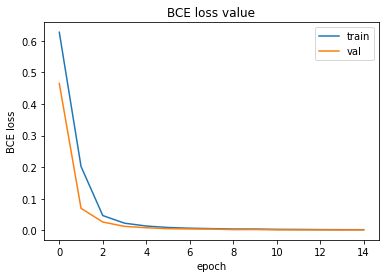

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

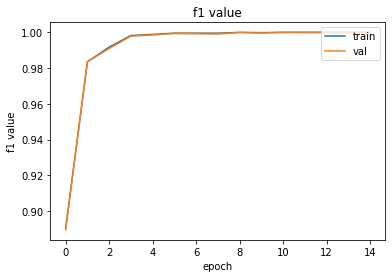

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.999755058051242

результат получился высоким. вывод: скобочки, смайлики и проч. сильно влияют на оценку тональности твитов. текст сам по себе не так важен, как символы, которыми он сопровождается. :)